<a href="https://colab.research.google.com/github/Folkas/folkas-portfolio/blob/main/Fake_news_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Classifier

Fake news is a relatively new phenomenon in the information age. However, its impact is not to be neglected because the transmission of fake news has both a social and especially a political impact.
If in ancient Greece, Aristotle first made order in the discourses of politicians or sophists, it is our duty to make the same order in our century. The project below is an ambitious attempt to create models to detect fake news.

We will use https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset dataset from Kaggle.


Kaggle is a platform that has various databases. The platform constantly supports project competitions in Data Science, awarded according to their quality. The database we will use was originally intended for such a contest, during which you have the right to use any source of information to build your model, you can even be inspired by the code of other competitors.
However, our project was not part of the competition and we tried to write the code ourselves, the goal being to learn.


---

## Requirements

#### General requirements for projects are as follow:

- Do Exploratory Data Analysis
- Try to find most predictive features from your data and use heuristic rules as your baseline
- Make 2+ ML models (LogReg, RandomForest, NaiveBayes, BootsedTrees, ...) with engineered features.
- Clearly describe your thought process and reasoning in the notebook.
- Compare performances of all models. Which one is the best? Why?
- Analyze the misclassified items, understand and present why are they harder for the model to guess.

#### Presentation
Make a presentation about the project: 
- Describe your work (data, model, results)
- Identify biggest challenges
- Suggest areas for improvement of you approach


## Evaluation Criteria

- Demonstration of ML engineering skills 
- Aggregate model performance
- Code quality
- Delivery of the presentation

## Bonus challenges

- Study your model with model interpretability tools, like Lime

# Project

This task asks me to create several ML models to classify given news articles into real or fake news labels. The dataset consists of nearly 45 000 articles, however, after cleaning duplicates, around 38 000 ones are left in the data set. Each entry contains article text, title, subject, publishing date and its label (0 for real news and 1 for fake news).

In [ ]:
%%capture
!pip install pytorch-lightning lime optuna transformers

In [ ]:
pip install wordcloud

In [ ]:
# for visualizations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

pd.set_option(
    "display.float_format", lambda x: "%.3f" % x
)  # setting options to display 3 decimal values

# for data preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import re

# for ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import optuna
from lightgbm import LGBMClassifier
import lightgbm as lgb

# sets seeds for numpy, python.random and PYTHONHASHSEED.
random_seed = seed_everything(8, workers=True)

# for model evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    f1_score,
)

import datetime
import time

# for prediction analysis
import lime
from lime.lime_text import LimeTextExplainer

Global seed set to 8


In [ ]:
# # uploading true labels dataset
true = pd.read_csv("D:/Kaggle/FakeNews/True.csv")
true["target"] = 0

# # uploading fake labels dataset
fake = pd.read_csv("D:/Kaggle/FakeNews/Fake.csv")
fake["target"] = 1

# # concatenating both datasets into one
df = pd.concat([true, fake], ignore_index=True)

# # saving the dataset in csv file
df.to_csv("fakenews_labels.csv")

In [ ]:
def clean_text(text: str) -> str:
  """
 ## Cleans input text from noise, such as http links, paragraph breaks, digits, punctuation marks and multiple spaces. The function also lowers all uppercase letters.
  """
  text = text.lower()  # lowers all words
  text = re.sub("https?://\S+|www\.\S+", "", text)  # removes all links
  text = re.sub("pic.twitter.\S+", "", text)  # removes tweet links
  text = re.sub("\n", " ", text)  # removes paragraph breaks
  text = re.sub("\w*\d\w*", "", text)  # removes all digits
  text = re.sub(
      '[/#$%^"&*():=‘’]', " ", text
  )  # removes unnecessary punctuation marks
  text = re.sub(" {2,}", " ", text)  # removes multiple spaces
  text = "".join([w for w in text if "@" not in w])  # removes hashtags
  stopwords = ["getty images", "featured image"]
  text = " ".join(
      [word for word in text.split() if word not in stopwords]
  )  # removes special stopwords from the text
  return text


def model_evaluation(y_true, y_preds):
  """
## Evaluates classifier model performance by plotting classification report and confusion matrix from model predictions and true labels.
  Parameters:
        * y_true: true label values
        * titley_preds: estimated labels returned by a model
    Returns:
        * classification report
        * confusion matrix
  """

  print(f"{' '*20} Classification report")
  print(
      classification_report(
          y_true, y_preds, zero_division=0, target_names=["Real news", "Fake news"]
      )
  )

  conf_matrix = confusion_matrix(y_true, y_preds)

  f, axes = plt.subplots(1, 1, figsize=(10, 5))

  disp = ConfusionMatrixDisplay(
      conf_matrix, display_labels=["Real news", "Fake news"]
  )
  disp.plot(ax=axes, values_format=".5g")
  disp.ax_.set_title(f"Confusion matrix for news classification")

In [ ]:
df = pd.read_csv("D:/Kaggle/FakeNews/fakenews_labels.csv", index_col=0)
df["Label"] = df.target.map({0: "Real news", 1: "Fake news"})
pd.set_option('display.max_colwidth', None)
df.head(3)

title  ...      Label
0  As U.S. budget fight looms, Republicans flip their fiscal script  ...  Real news
1  U.S. military to accept transgender recruits on Monday: Pentagon  ...  Real news
2      Senior U.S. Republican senator: 'Let Mr. Mueller do his job'  ...  Real news

[3 rows x 6 columns]

In [ ]:
print("Total samples:", len(df))

Total samples: 44898


In [ ]:
df[["title"]].value_counts().head(10)

title                                                                                                
Factbox: Trump fills top jobs for his administration                                                     14
Factbox: Contenders for senior jobs in Trump's administration                                             8
Highlights: The Trump presidency on April 13 at 9:30 P.M. EDT/0130 GMT on Friday                          8
Factbox: International reaction to arrest of Reuters reporters in Myanmar                                 6
MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead     6
Factbox: Contenders, picks for key jobs in Trump's administration                                         5
Highlights: The Trump presidency on March 31 at 6:19 p.m. EDT                                             5
Highlights: The Trump presidency on April 21 at 6:12 p.m. EDT/2212 GMT                                    5
Factbox: Contenders for key jobs i

We can see that the data set is not clean, as it contains many duplicates. For instance, some article titles repeat 14 times across the data set! Analyzing data, I also discovered that some articles duplicate on title and others on text.

In [ ]:
# total number of duplicates
len(
    df[
        (df.duplicated(subset=["title"], keep="first"))
        | (df.duplicated(subset=["text"], keep="first"))
    ]
)

6628

There are 6628 article title or text duplicates in the dataset in total, so I'll remove them.

In [ ]:
df = df.drop_duplicates(subset="title").drop_duplicates(subset="text")
df.shape

(38270, 6)

We can see that after removing duplicates, 38 270 observations are left.




In [ ]:
# checking if the dataset is clean
df.isna().sum()

title      0
text       0
subject    0
date       0
target     0
Label      0
dtype: int64

In [ ]:
# checking if the dataset is clean
df.isnull().any()

title      False
text       False
subject    False
date       False
target     False
Label      False
dtype: bool

There are no null values, so the dataset is clean.

Text(0, 0.5, '')

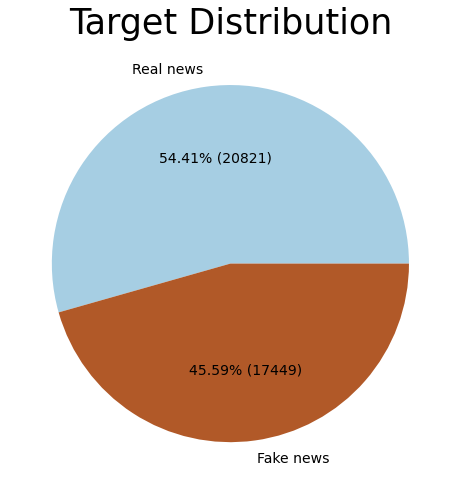

In [ ]:
target_distribution = df.groupby("target").size()

target_distribution.plot(
    kind="pie",
    autopct=lambda p: "{:.2f}% ({:.0f})".format(
        p, (p / 100) * target_distribution.sum()
    ),
    fontsize=14,
    labels=["Real news", "Fake news"],
    figsize=(8, 10),
    title="Target Distribution",
    colormap="Paired",
).title.set_size(35)
plt.ylabel("")

Before cleaning there were 21 211 real news and 23 478 fake news articles in the dataset. After cleaning, there remained 20 821 real and 17 449 fake news articles. We can see that there are more real news articles, but the difference does not seem too large so balancing the labels is not needed.

Text(-8.700000000000003, 0.5, 'Count')

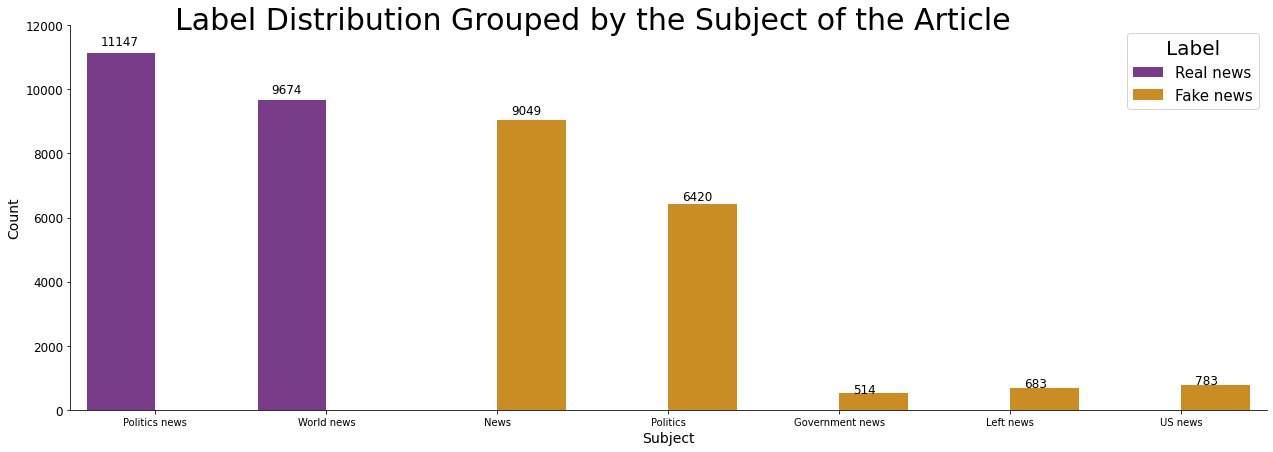

In [ ]:
h = sns.catplot(
    data=df, hue="target", x="subject", kind="count", palette="CMRmap", legend=False
)
h.set_yticklabels(size=12)
h.fig.set_size_inches(20, 6)
h.fig.suptitle(
    "Label Distribution Grouped by the Subject of the Article", fontsize=30, va="center"
)
subject_labels = [
    "Politics news",
    "World news",
    "News",
    "Politics",
    "Government news",
    "Left news",
    "US news",
    "Middle East",
]
h.set_xticklabels(subject_labels, size=10)
ax = h.facet_axis(0, 0)
for p in ax.patches:
    if p.get_height() > 0:
        ax.text(
            p.get_x() + 0.08,
            p.get_height() * 1.02,
            "{0:.0f}".format(p.get_height()),
            color="black",
            rotation="horizontal",
            size="large",
        )
plt.legend(
    title="Label",
    loc="upper right",
    fontsize=15,
    title_fontsize=20,
    labels=["Real news", "Fake news"],
)
plt.xlabel("Subject", fontsize=14)
plt.ylabel("Count", fontsize=14)

The barplot above depicts real and fake news articles grouped by subject categories. What comes to attention is that real news articles are either politics or world news. Meanwhile, fake news articles can be grouped into 5 categories: news, politics, government news, left news and US news. However, the subjects "Politics news" and "Politics" seem as the same category, so different categories could appear during the labelling process and could be an error.

In fact, before cleaning there were 8 subject categories, but after cleaning the duplicates the Middle East subject no longer exists.

In [ ]:
df["text_length"] = df["text"].map(lambda x: len(x.split()))
df["title_length"] = df["title"].map(lambda x: len(x.split()))

fake_describe = df[df.target == 1][["text_length", "title_length"]].describe()
real_describe = df[df.target == 0][["text_length", "title_length"]].describe()
pd.concat([real_describe, fake_describe], axis=1, keys=["Real news", "Fake news"])

Real news                Fake news             
      text_length title_length text_length title_length
count   20821.000    20821.000   17449.000    17449.000
mean      383.163        9.951     425.146       14.318
std       271.230        1.697     354.850        3.956
min         0.000        4.000       0.000        1.000
25%       149.000        9.000     277.000       12.000
50%       358.000       10.000     376.000       14.000
75%       520.000       11.000     503.000       16.000
max      5172.000       20.000    8135.000       42.000

I've created two more features: ```text_length``` (word length of article) and ```title_length``` (word length of headline) and grouped them by the label categories. The histograms below explain both features.

Text(0.5, 1.0, 'Title Length Histogram by News Labels')

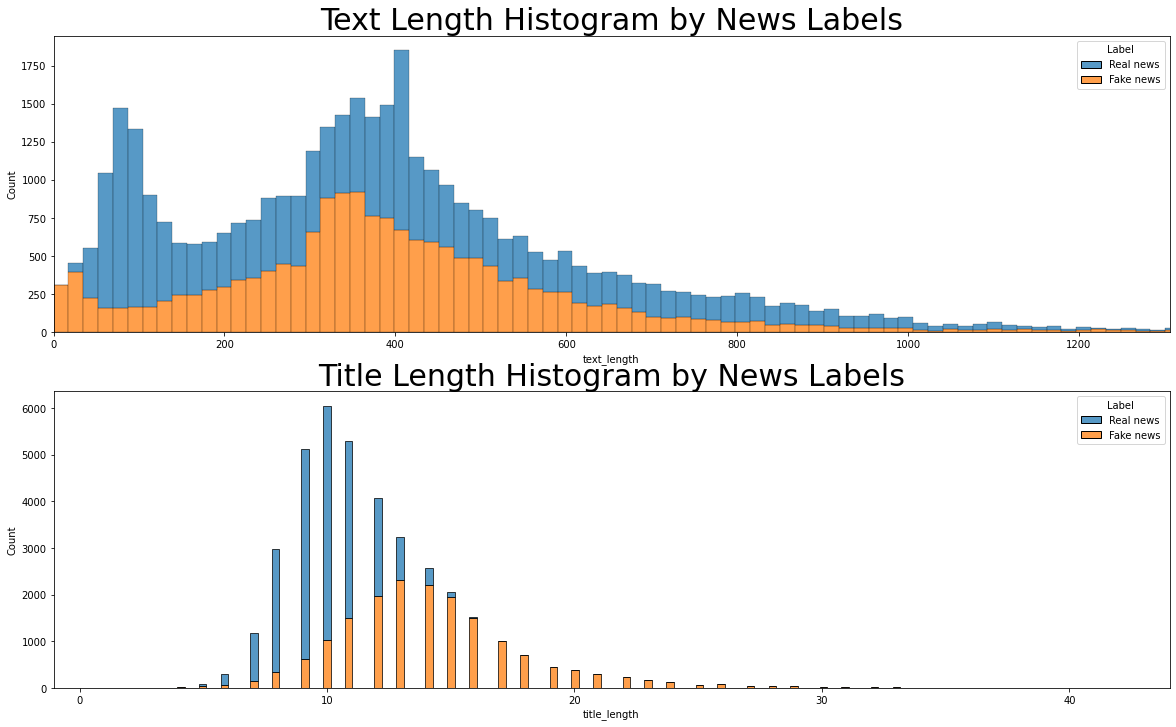

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

g = sns.histplot(data=df, x="text_length", hue="Label", multiple="stack", ax=ax1)
g.set_title("Text Length Histogram by News Labels", fontsize=30)
g.set(xlim=(0, df.text_length.quantile(0.99)))

h = sns.histplot(data=df, x="title_length", hue="Label", multiple="stack", ax=ax2)
h.set_title("Title Length Histogram by News Labels", fontsize=30)

Looking at the plots above, we can see that when it comes to text length, both real and fake news articles follow similar patterns. But what comes to attention is that there are almost 300 fake news articles with text length equal or near to 0.

On the other hand, we can observe differences in headline title length. Real news headlines stretch up to 20 words, whereas fake news article titles are usually much longer.

Next, I will overview most frequent words within real and fake news articles in wordclouds below.

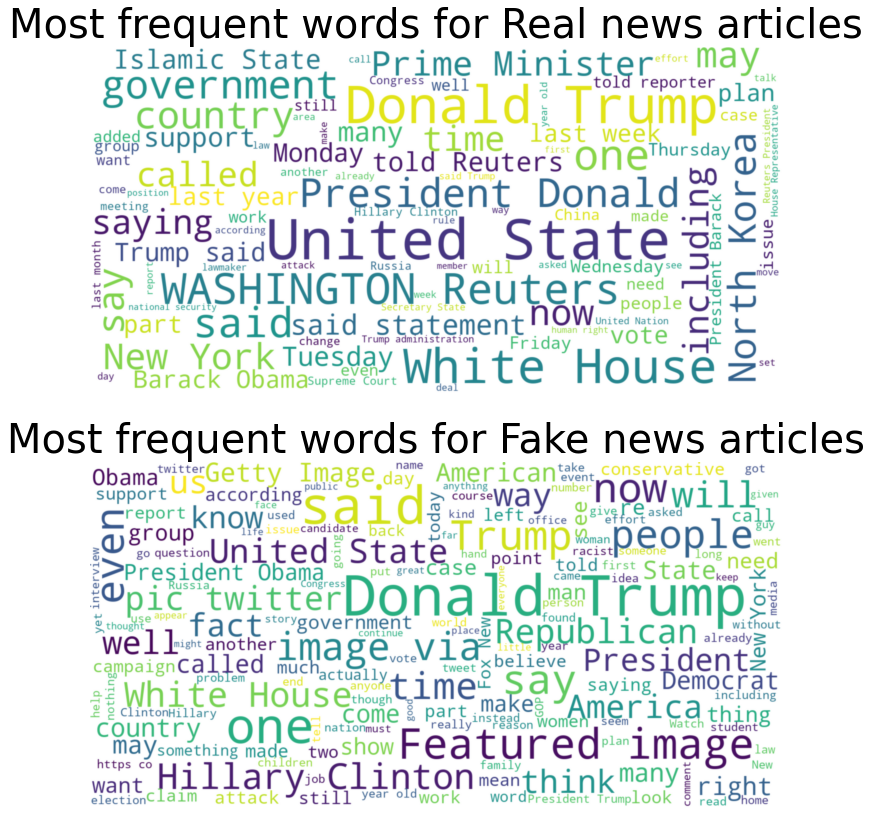

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))
for i, k in enumerate(["Real news", "Fake news"]):
    words = " ".join([text for text in df[df.Label == k]["text"]])
    word_cloud = WordCloud(
        normalize_plurals=True,
        width=1600,
        height=800,
        margin=0,
        max_words=500,
        max_font_size=130,
        min_font_size=20,
        background_color="white",
    ).generate(words)
    ax[i].set_title(f"Most frequent words for {k} articles", fontsize=40)
    ax[i].imshow(word_cloud, interpolation="gaussian")
    ax[i].axis("off")

As we can see, the most frequent words in both real and fake news articles are very similar.

Before creating models, I will clean article texts from http or tweet links, hashtags, paragraph breaks, digits, unnecessary words ("Getty images" or "featured image") and will lower all words. 

In [ ]:
# cleaning text
df["text"] = df.text.map(clean_text)

**Train-val-test split**

I will also split the dataset into train and test datasets. This stage is a preparation for implementing machine machine learning models.

In [ ]:
# merging article titles and text into one
df["all_text"] = df["title"] + " " + df["text"]
my_cols = ["all_text", "text_length", "title_length"]
X = df[my_cols]
Y = df[["target"]]
# splitting the data set into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(
    X.values, Y.values, test_size=0.20, random_state=random_seed
)

X_train = pd.DataFrame(
    X_train, columns=X.columns
)  
test_X = pd.DataFrame(test_X, columns=X.columns)  # to be used for ML models

## Models

In this section I will create heuristic and machine learning models. I will compare each model's performance based on several criteria: inference time (in ms) for a batch of 16 inputs, weighted F1 score as well as the number of false negatives and false positives. I chose the latter two over precision and recall scores, because several models have precision and recall equal to 1.00 due to rounding. Therefore, incluing the number of false predictions into the comparison table is more accurate.

**Heuristic model**

As the task requires, I will now create a rule-based model as a baseline to compare with other models.

Using TfidfVectorizer, I obtained 50 most frequent unigrams, bi-grams and tri-grams for real and fake news article texts.

In [ ]:
words = TfidfVectorizer(ngram_range=(1, 3), max_features=50, stop_words="english")
words.fit(df.loc[df.Label == "Fake news"]["text"])
fake_words = words.get_feature_names()

words.fit(df.loc[df.Label == "Real news"]["text"])
real_words = words.get_feature_names()

pd.DataFrame([fake_words, real_words], index=["fake news", "real news"]).T

,fake news,real news
0,according,administration
1,america,campaign
2,american,china
3,campaign,clinton
4,clinton,country
5,country,court
6,did,democratic
7,don,donald
8,donald,donald trump
9,donald trump,election


Among most frequent words we find politician names (Donald Trump, Barack Obama, (Hillary) Clinton), political terms (elections, president, party, politician, republican, senate) and so on. Because these words repeat in all articles, they will not help me to classify articles. However, there is one word in the list repeating across real news articles - "reuters". Reuters is the news agency, so articles published by Reuters have the agency's title at the beginning of the text.

In [ ]:
df[df.text.str.contains("reuters", case=False)]["Label"].value_counts()

Real news    20785
Fake news      219
Name: Label, dtype: int64

Unbelievable, but using only one word we can extract almost 20,790 real news articles (20,826 in total), or more than 99% of all real news labels! Therefore, I can create a rule-based model, which classifies the articles whethere they contain the word "reuters" in the text or not. I also considered using ```title_length``` variable for the heuristic model. As we saw in EDA part, most real news articles have title length below 11, so I could include this rule to the heuristic model. However, predicting labels based on the single word "reuters" proved to be more accurate.

In [ ]:
def get_label(text: str) -> bool:
  """
  Returns article label (0 for real news and 1 for fake news) based on whether the text contains a word "reuters"
  """
  if "reuters" in str(text).lower():
      return 0
  else:
      return 1
  
# I considered including the rules below to the model, but predicting the labels solely on the word "reuters" proved more accurate
  # if df.loc[(df.title_length >11):
  #   return 1
  # else:
  #   return 0

In [ ]:
start = time.time()
y_preds_heuristic = [get_label(text) for text in test_X["all_text"]]
end = time.time()

In [ ]:
print(
    "Average inference time for a batch of 16 entries is {:.4f} ms\n".format(
        16 * (end - start) / len(X_test)
    )
)

Average inference time for a batch of 16 entries is 0.0001 ms



                     Classification report
              precision    recall  f1-score   support

   Real news       0.99      1.00      1.00      2023
   Fake news       1.00      0.99      0.99      1804

    accuracy                           0.99      3827
   macro avg       1.00      0.99      0.99      3827
weighted avg       0.99      0.99      0.99      3827



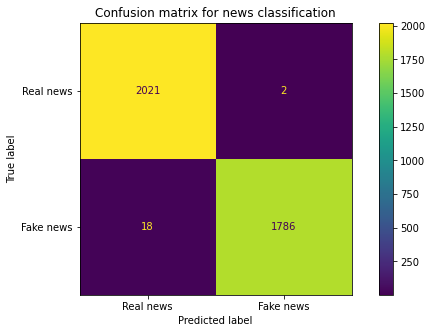

In [ ]:
model_evaluation(test_y, y_preds_heuristic)

Looking into the model evaluation table, we can see that the rule-based model nearly perfectly predicts real and fake news articles. Also, the batch inference time (0.0001 ms) is very small!

**ML models**

For this task I will constrain 3 classifier machine learning models: **Logistic Regression, Random Forest and Light Gradient Boosting Machine**. I will use TfidfVectorizer to extract matrices with 50 TF-IDF features from the dataset. These matrices will be used to train the models. For each model I will create three versions: 

1. Baseline with no hyperparameter tuning; 
2. The one with feature importance, which selects features based on importance weights; 
3. The one with hyperparameters tuned with Optuna (and selected features if the second version delivers higher F1 score)


**Logistic Regression** 

- Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable.

**Random Forest Alghoritm**

- The random forest is a classification algorithm consisting of many decisions trees

**Light Gradient Boosting Machine** 

- Gradient Boosting Algorithm is an algorithm that combines the predictions from multiple decision trees to generate the final predictions. The main distinction between Random Forst Alghoritm and Gradient Boosting Alghoritm is that random forests builds each tree independently while gradient boosting builds one tree at a time.

**Optuna** 
- An optimization library in Python that can be employed for hyperparameter optimization. It automatically finds optimal hyperparameter values by making use of different samplers such as grid search, random, bayesian, and evolutionary algorithms.

**Logistic Regression Classifier**

**Baseline model**

In [ ]:
words = TfidfVectorizer(ngram_range=(1, 3), max_features=50, stop_words="english")
preprocessor = ColumnTransformer(
    transformers=[
        ("for_text", words, "all_text"),
    ]
)

pipe = Pipeline(
    steps=[
        ("feature_engineering", preprocessor),
        ("model", LogisticRegression(random_state=random_seed, multi_class="ovr")),
    ]
)

In [ ]:
pipe.fit(X_train, y_train)
start = time.time()
y_preds_logreg_baseline = pipe.predict(test_X)
end = time.time()
print(
    "Average inference time for a batch of 16 entries is {:.3f} ms\n".format(
        16 * (end - start) / len(test_y)
    )
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Average inference time for a batch of 16 entries is 0.012 ms



                     Classification report
              precision    recall  f1-score   support

   Real news       0.98      0.99      0.99      2023
   Fake news       0.99      0.98      0.98      1804

    accuracy                           0.98      3827
   macro avg       0.98      0.98      0.98      3827
weighted avg       0.98      0.98      0.98      3827



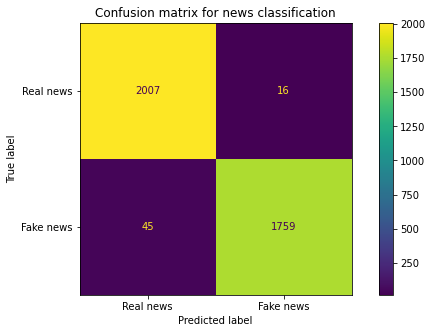

In [ ]:
model_evaluation(test_y, y_preds_logreg_baseline)

**Feature Importance**

In [ ]:
words = TfidfVectorizer(ngram_range=(1, 3), max_features=50, stop_words="english")
preprocessor = ColumnTransformer(
    transformers=[
        ("for_text", words, "all_text"),
    ]
)
selector = SelectFromModel(
    estimator=LogisticRegression(random_state=random_seed, multi_class="ovr"),
    threshold="0.3*mean",
)
pipe_sfm = Pipeline(
    steps=[
        ("feature_engineering", preprocessor),
        ("feature importance", selector),
        ("model", LogisticRegression(random_state=random_seed, multi_class="ovr")),
    ]
)
pipe_sfm.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Pipeline(memory=None,
         steps=[('feature_engineering',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('for_text',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                

In [ ]:
start = time.time()
y_preds_logreg_sfm = pipe_sfm.predict(test_X)
end = time.time()

print(
    "Average inference time for a batch of 16 entries is {:.3f} ms\n".format(
        16 * (end - start) / len(test_X)
    )
)

Average inference time for a batch of 16 entries is 0.012 ms



                     Classification report
              precision    recall  f1-score   support

   Real news       0.98      0.99      0.98      2023
   Fake news       0.99      0.97      0.98      1804

    accuracy                           0.98      3827
   macro avg       0.98      0.98      0.98      3827
weighted avg       0.98      0.98      0.98      3827



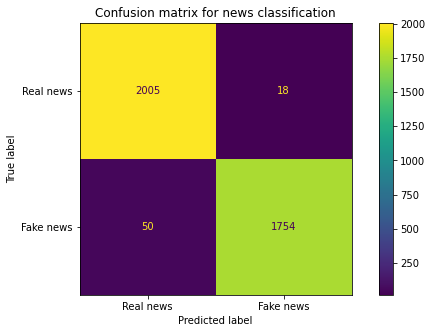

In [ ]:
model_evaluation(test_y, y_preds_logreg_sfm)

**Optuna**

In [ ]:
words = TfidfVectorizer(ngram_range=(1, 3), max_features=50, stop_words="english")
preprocessor = ColumnTransformer(
    transformers=[
        ("for_text", words, "all_text"),
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(test_X)

In [ ]:
%%capture
def objective(trial):
    param = {
        "tol": trial.suggest_float("tol", 1e-8, 1.0),
        "C": trial.suggest_float("C", 1e-8, 5.0),
        "l1_ratio": trial.suggest_float("l1_ratio", 1e-8, 1.0),
        "penalty": trial.suggest_categorical("penalty", ["l2", "none"]),
    }
    clf = LogisticRegression(random_state=random_seed, multi_class="ovr", **param)
    clf.fit(X_train_transformed, y_train)
    preds = clf.predict(X_test_transformed)
    f1s = f1_score(test_y, preds, average="weighted")
    return f1s


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=False)

In [ ]:
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("  Value: {}".format(study.best_trial.value))

Number of finished trials: 30
Best trial: {'tol': 0.9792945036456808, 'C': 0.4844741584678882, 'l1_ratio': 0.8388781888768029, 'penalty': 'none'}
  Value: 0.9934665494757102


In [ ]:
logreg_optuna_params = {
    "tol": 0.9792945036456808,
    "C": 0.4844741584678882,
    "l1_ratio": 0.8388781888768029,
    "penalty": "none",
}

pipe_sfm = Pipeline(
    steps=[
        ("feature_engineering", preprocessor),
        (
            "model",
            LogisticRegression(
                random_state=random_seed, multi_class="ovr", **logreg_optuna_params
            ),
        ),
    ]
)
pipe_sfm.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Pipeline(memory=None,
         steps=[('feature_engineering',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('for_text',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                

In [ ]:
start = time.time()
y_preds_logreg_optuna = pipe_sfm.predict(test_X)
end = time.time()

In [ ]:
print(
    "Average inference time for a batch of 16 entries is {:.3f} ms\n".format(
        16 * (end - start) / len(test_y)
    )
)

Average inference time for a batch of 16 entries is 0.012 ms



                     Classification report
              precision    recall  f1-score   support

   Real news       0.99      1.00      0.99      2023
   Fake news       1.00      0.99      0.99      1804

    accuracy                           0.99      3827
   macro avg       0.99      0.99      0.99      3827
weighted avg       0.99      0.99      0.99      3827



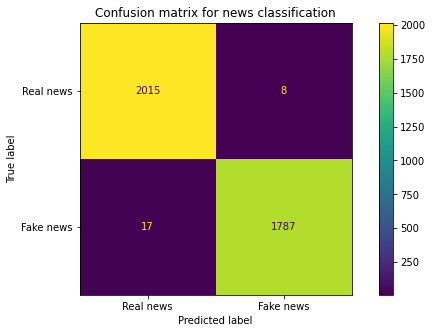

In [ ]:
model_evaluation(test_y, y_preds_logreg_optuna)

To summarize all logistic regression models, all of them share the same batch inference time (0.012 ms), while the model with tuned hyperparameters has the best metrics (F1 score, FNs and FPs) out of three modifications.

**Random Forest Classifier**


**Baseline model**

In [ ]:
words = TfidfVectorizer(ngram_range=(1, 3), max_features=50, stop_words="english")
preprocessor = ColumnTransformer(
    transformers=[
        ("for_text", words, "all_text"),
    ]
)

pipe = Pipeline(
    steps=[
        ("feature_engineering", preprocessor),
        ("model", RandomForestClassifier(random_state=random_seed)),
    ]
)
pipe.fit(X_train, y_train)

In [ ]:
start = time.time()
y_preds_rf_baseline = pipe.predict(test_X)
end = time.time()

In [ ]:
print(
    "Average inference time for a batch of 16 entries is {:.3f} ms\n".format(
        16 * (end - start) / len(test_X)
    )
)

Average inference time for a batch of 16 entries is 0.012 ms



                     Classification report
              precision    recall  f1-score   support

   Real news       0.99      1.00      1.00      2023
   Fake news       1.00      0.99      0.99      1804

    accuracy                           1.00      3827
   macro avg       1.00      1.00      1.00      3827
weighted avg       1.00      1.00      1.00      3827



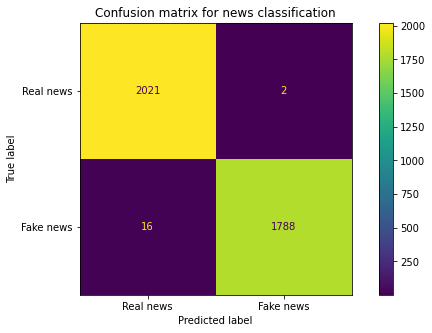

In [ ]:
model_evaluation(test_y, y_preds_rf_baseline)

**Feature Importance**

In [ ]:
selector = SelectFromModel(
    estimator=RandomForestClassifier(random_state=random_seed),
    threshold='0.3*mean'
)
pipe_sfm = Pipeline(
    steps=[
        ("feature_engineering", preprocessor),
        ("feature importance", selector),
        ("model", RandomForestClassifier(random_state=random_seed)),
    ]
)
pipe_sfm.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Pipeline(memory=None,
         steps=[('feature_engineering',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('for_text',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                

In [ ]:
start = time.time()
y_preds_rf_sfm = pipe_sfm.predict(test_X)
end = time.time()

In [ ]:
print(
    "Average inference time for a batch of 16 entries is {:.3f} ms\n".format(
        16 * (end - start) / len(test_X)
    )
)

Average inference time for a batch of 16 entries is 0.012 ms



                     Classification report
              precision    recall  f1-score   support

   Real news       0.99      1.00      0.99      2023
   Fake news       1.00      0.99      0.99      1804

    accuracy                           0.99      3827
   macro avg       0.99      0.99      0.99      3827
weighted avg       0.99      0.99      0.99      3827



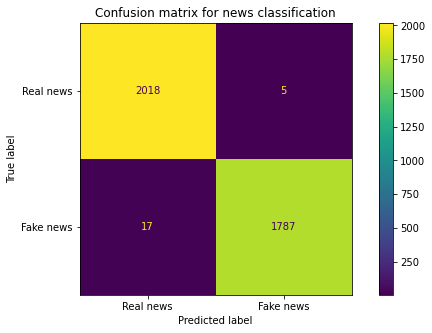

In [ ]:
model_evaluation(test_y, y_preds_rf_sfm)

**Optuna**

In [ ]:
selector = SelectFromModel(
    estimator=RandomForestClassifier(random_state=random_seed),
    threshold='0.3*mean'
)
pipe_optuna = Pipeline(
    steps=[
        ("feature_engineering", preprocessor),
        ("feature importance", selector)
    ]
)
pipe_optuna.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Pipeline(memory=None,
         steps=[('feature_engineering',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('for_text',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                

In [ ]:
X_train_transformed = pipe_optuna.transform(X_train)
X_test_transformed = pipe_optuna.transform(test_X)

In [ ]:
%%capture
def objective(trial):
    param = {
        "random_state": random_seed,
        "n_estimators": trial.suggest_int("n_estimators", 1, 1000, log=True),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "max_features": trial.suggest_categorical(
            "max_features", ["auto", "sqrt", "log2"]
        ),
        "min_samples_split": trial.suggest_float(
            "min_samples_split", 1e-8, 1.0, log=True
        ),
        "class_weight": trial.suggest_categorical(
            "class_weight", ["balanced", "balanced_subsample"]
        ),
    }
    clf = RandomForestClassifier(**param)
    clf.fit(X_train_transformed, y_train)
    preds = clf.predict(X_test_transformed)
    f1s = f1_score(test_y, preds, average="weighted")
    return f1s


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

In [ ]:
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("  Value: {}".format(study.best_trial.value))

Number of finished trials: 30
Best trial: {'n_estimators': 237, 'criterion': 'gini', 'max_depth': 28, 'max_features': 'log2', 'min_samples_split': 0.02059392717646446, 'class_weight': 'balanced'}
  Value: 0.9950340813766563


In [ ]:
rfc_optuna_params = {
    "n_estimators": 237,
    "criterion": "gini",
    "max_depth": 28,
    "max_features": "log2",
    "min_samples_split": 0.02059392717646446,
    "class_weight": "balanced",
}

selector = SelectFromModel(
    estimator=RandomForestClassifier(random_state=random_seed, **rfc_optuna_params),
    threshold="0.3*mean",
)
pipe_sfm = Pipeline(
    steps=[
        ("feature_engineering", preprocessor),
        ("feature importance", selector),
        (
            "model",
            RandomForestClassifier(random_state=random_seed, **rfc_optuna_params),
        ),
    ]
)
pipe_sfm.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Pipeline(memory=None,
         steps=[('feature_engineering',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('for_text',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                

In [ ]:
start = time.time()
y_preds_rf_optuna = pipe_sfm.predict(test_X)
end = time.time()


In [ ]:
print(
    "Average inference time for a batch of 16 entries is {:.3f} ms\n".format(
        16 * (end - start) / len(test_X)
    )
)

Average inference time for a batch of 16 entries is 0.012 ms



                     Classification report
              precision    recall  f1-score   support

   Real news       0.99      1.00      1.00      2023
   Fake news       1.00      0.99      0.99      1804

    accuracy                           1.00      3827
   macro avg       1.00      0.99      1.00      3827
weighted avg       1.00      1.00      1.00      3827



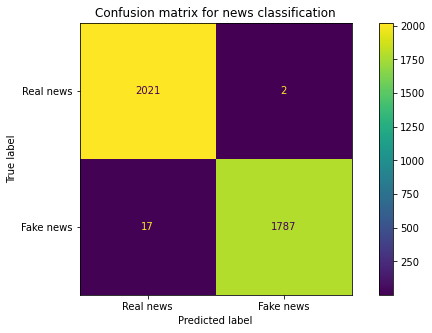

In [ ]:
model_evaluation(test_y, y_preds_rf_optuna)

We can see that random forest models again have the same batch inference time as logistic regression models. However, the baseline model with no hyperparameter tuning seems to have fewer FNs and FPs than the tuned model, while both sharing perfect 1.00 F1 score.

**Light Gradient Boosted Machine Classifier**

##### Baseline model

In [ ]:
words = TfidfVectorizer(ngram_range=(1, 3), max_features=50, stop_words="english")
preprocessor = ColumnTransformer(
    transformers=[
        ("for_text", words, "all_text"),
    ]
)

pipe = Pipeline(
    steps=[
        ("feature_engineering", preprocessor),
        ("model", LGBMClassifier(data_random_seed=random_seed)),
    ]
)

In [ ]:
pipe.fit(X_train, y_train)
start = time.time()
y_preds_lgbc_baseline = pipe.predict(test_X)
end = time.time()


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
print(
    "Average inference time for a batch of 16 entries is {:.3f} ms\n".format(
        16 * (end - start) / len(test_X)
    )
)

Average inference time for a batch of 16 entries is 0.012 ms



                     Classification report
              precision    recall  f1-score   support

   Real news       0.99      1.00      1.00      2023
   Fake news       1.00      0.99      0.99      1804

    accuracy                           1.00      3827
   macro avg       1.00      1.00      1.00      3827
weighted avg       1.00      1.00      1.00      3827



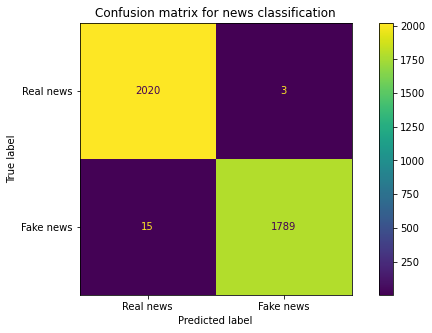

In [ ]:
model_evaluation(test_y, y_preds_lgbc_baseline)

**Feature Importance**

In [ ]:
words = TfidfVectorizer(ngram_range=(1, 3), max_features=50, stop_words="english")
preprocessor = ColumnTransformer(
    transformers=[
        ("for_text", words, "all_text"),
    ]
)
selector = SelectFromModel(
    estimator=LGBMClassifier(data_random_seed=random_seed),
    threshold='0.3*mean'
)
pipe_sfm = Pipeline(
    steps=[
        ("feature_engineering", preprocessor),
        ("feature importance", selector),
        ("model", LGBMClassifier(data_random_seed=random_seed)),
    ]
)
pipe_sfm.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Pipeline(memory=None,
         steps=[('feature_engineering',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('for_text',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                

In [ ]:
start = time.time()
y_preds_lgbc_sfm = pipe_sfm.predict(test_X)
end = time.time()

print(
    "Average inference time for a batch of 16 entries is {:.3f} ms\n".format(
        16 * (end - start) / len(test_X)
    )
)

Average inference time for a batch of 16 entries is 0.012 ms



                     Classification report
              precision    recall  f1-score   support

   Real news       0.99      1.00      1.00      2023
   Fake news       1.00      0.99      0.99      1804

    accuracy                           1.00      3827
   macro avg       1.00      0.99      1.00      3827
weighted avg       1.00      1.00      1.00      3827



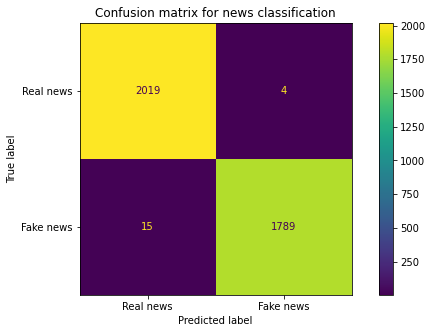

In [ ]:
model_evaluation(test_y, y_preds_lgbc_sfm)

**Optuna**

In [ ]:
words = TfidfVectorizer(ngram_range=(1, 3), max_features=50, stop_words="english")
preprocessor = ColumnTransformer(
    transformers=[
        ("for_text", words, "all_text"),
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(test_X)

In [ ]:
%%capture
train_df = lgb.Dataset(
    data=X_train_transformed,
    label=y_train.reshape(-1),
    free_raw_data=False,
)
test_def = lgb.Dataset(data=X_test_transformed, label=test_y.reshape(-1))

def objective(trial):
  param = {
    "objective": "multiclass",
    "num_class": 5,
    "verbosity": -1,
    "feature_pre_filter": False,
    "data_random_seed": random_seed,
    "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
    "num_iterations": trial.suggest_int("num_iterations", 1, 1000),
    "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
    "num_leaves": trial.suggest_int("num_leaves", 2, 256),
    "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
    "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
    "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
    "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    "max_depth": trial.suggest_int("max_depth", 0, 11),
    "num_leaves": trial.suggest_int("num_leaves", 2, 256),
    "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 1.0),
    "boosting": trial.suggest_categorical("boosting", ["gbdt", "rf", "dart"]),
    }
  gbm = lgb.train(param, train_df, valid_sets=test_def, verbose_eval=False)
  preds = gbm.predict(X_test_transformed).argmax(axis=1)
  f1s = f1_score(test_y, preds, average='weighted')
  return f1s


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=False)

In [ ]:
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("  Value: {}".format(study.best_trial.value))

Number of finished trials: 30
Best trial: {'lambda_l1': 1.2504648397855519e-06, 'num_iterations': 533, 'lambda_l2': 0.004685039733656705, 'num_leaves': 6, 'feature_fraction': 0.46564012483315786, 'bagging_fraction': 0.9020501779991563, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 10, 'learning_rate': 0.26727981999229444, 'boosting': 'dart'}
  Value: 0.9958186592890986


In [ ]:
params_lgbc_optuna = {
    "lambda_l1": 1.2504648397855519e-06,
    "num_iterations": 533,
    "lambda_l2": 0.004685039733656705,
    "num_leaves": 6,
    "feature_fraction": 0.46564012483315786,
    "bagging_fraction": 0.9020501779991563,
    "bagging_freq": 2,
    "min_child_samples": 82,
    "max_depth": 10,
    "learning_rate": 0.26727981999229444,
    "boosting": "dart",
}
words = TfidfVectorizer(ngram_range=(1, 3), max_features=50, stop_words="english")
preprocessor = ColumnTransformer(
    transformers=[
        ("for_text", words, "all_text"),
    ]
)

pipe = Pipeline(
    steps=[
        ("feature_engineering", preprocessor),
        ("model", LGBMClassifier(data_random_seed=random_seed, **params_lgbc_optuna)),
    ]
)

In [ ]:
pipe.fit(X_train, y_train)
start = time.time()
y_preds_lgbc_optuna = pipe.predict(test_X)
end = time.time()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



In [ ]:
print(
    "Average inference time for a batch of 16 entries is {:.3f} ms\n".format(
        16 * (end - start) / len(test_X)
    )
)

Average inference time for a batch of 16 entries is 0.012 ms



                     Classification report
              precision    recall  f1-score   support

   Real news       0.99      1.00      1.00      2023
   Fake news       1.00      0.99      1.00      1804

    accuracy                           1.00      3827
   macro avg       1.00      1.00      1.00      3827
weighted avg       1.00      1.00      1.00      3827



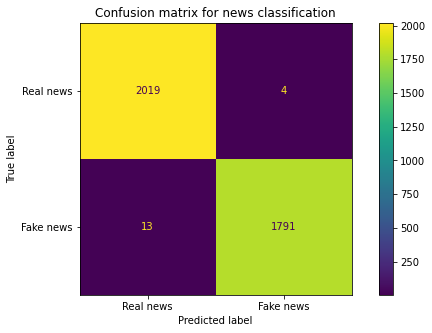

In [ ]:
model_evaluation(test_y, y_preds_lgbc_optuna)

To compare Light Gradient Boosted Machine model modifications, all three again have the same inference time as other scikit library models and share the same 1.00 F1 score. But looking at the number of FPs and FNs, the one with hyperparameters tuned by optuna is more precise.

**Conclusion**

**Summary**

This project aimed to create a model classifying news articles from kaggle dataset as real or fake news. I created heuristic, ML models to solve the problem. It turned out that the transformer model showed excellent performance, as it predicted all articles correctly. Therefore, I recommended this model for production, if the production team is concerned with model's accuracy. However, if the goal is to classify articles speedily, a simple heuristic model (article is real news if it contains word "reuters") could be an option too, as its inference time is shortest, compared with other models.